**TITLE**:
Using serum cholesterol and age to diagnose the presence of heart disease in patients from Cleveland.

**INTRODUCTION**:

Heart disease, also called cardiovascular disease affects the heart and blood vessels. One of the most common heart disease is the coronary artery disease, which comes from narrow or blocked coronary arteries. Risk factors increase the chance of developing this heart disease, including serum cholesterol levels and age. 

Serum cholesterol is a waxy substance found in the blood. With high cholesterol levels, fatty deposits develop in the blood vessels and the bloow flow becomes abnormal in the arteries, forming clots. Increasing age can also build up fatty deposits in the arteries over time, changing heart and blood vessels. Hence, increasing age and serum cholesterol levels could increase the risk of heart disease according to research. 

Therefore, my question is "Can age and serum cholesterol levels predit whether a new patient has heart disease?" To answer my question, I will use the K-nearest neighbors classification algorithm. 

I will use the processed.cleveland.data from the heart disease database. This data was originally from UCI Heart Disease Dataset (Cleveland Clinic) and I will be using predictors age and serum cholesterol (mg/dl) out of the listed columns to predict whether a new patient has heart disease using classification. 

**METHOD AND RESULTS**:

Firstly, I will clean and wrangle the data after reading the processed data. Then, the preprocessed data will be split into training and test set. The training set will be used to model the classifier. I also summarized the training set to make predictions and to see the relationship between the predictors. Lastly, I created a visualization of the training set between my two predictors to see the distribution.  


Finding the best $k$ value: 

To provide a high accuracy prediction, the best $k$ value will be used by performing cross-validation. 

1. I will create a recipe that scales the data.
2. Using `vfold_cv`, I will perform the 5 fold cross-validation to increase my accuracy estimate (lower standard error).
3. I will then create my model using `nearest_neighbour` and tune the classifer.
4. Using workflow, `tune_grid` will be used, along with adding the model and recipe.
5. Using `gridvals` will show the $k$ value range.
6. Finally, I will find the best $k$ value using a line plot (accuracy vs K-values plot).

For visualization, I will plot the age predictor on the x-axis, and serum cholesterol on the y-axis, colouring in the points for diagnosis (presence or absense of heart disease). The accuracy, precision and recall of my classifer will also be discussed. 

In [48]:
#importing packages
library(repr)
library(tidyverse)
library(tidymodels)
library(scales)
library(readr)

In [2]:
#setting seed
set.seed(3456) 

In [49]:
#loading data
cleveland_data <- read_csv("data/heart_disease/processed.cleveland.data", col_names = FALSE)
head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1 X2 X3 X4  X5  X6 X7 X8  X9 X10 X11 X12 X13 X14
1 63 1  1  145 233 1  2  150 0  2.3 3   0.0 6.0 0  
2 67 1  4  160 286 0  2  108 1  1.5 2   3.0 3.0 2  
3 67 1  4  120 229 0  2  129 1  2.6 2   2.0 7.0 1  
4 37 1  3  130 250 0  0  187 0  3.5 3   0.0 3.0 0  
5 41 0  2  130 204 0  2  172 0  1.4 1   0.0 3.0 0  
6 56 1  2  120 236 0  0  178 0  0.8 1   0.0 3.0 0

Figure 1

The data does not come with column names, so I need to add the names using `rename`. Then, I only need to select the columns I need for my analysis  which are age, serum cholesterol and num. Since I am using classification, I must mutate the num coloumn's data type into a categorical label.

In [52]:
selected_data <- cleveland_data |>
    rename(age = X1, cholesterol = X5, num = X14) |>
     select(num, cholesterol, age) |>
     mutate(num = as_factor(num)) 
head(selected_data)

num cholesterol age
1 0   233         63 
2 2   286         67 
3 1   229         67 
4 0   250         37 
5 0   204         41 
6 0   236         56

Figure 2

The diagnosis of heart disease column (num) shows that values 1 to 4 means that 50% of the diameter is narrowing, indicating the presence of heart disease. In contrast, value 0 indicates the absence of heart disease.

Hence, I will indicate the presence of heart disease for values 1,2,3,4 and indicate 0 as absence using `fct_recode`. This creates a new column called "diagnosis".

In [55]:
#Remove num column 
heart_data <- selected_data |>
    mutate(diagnosis = fct_recode(num,
                          "absence" = "0",
                          "presence" = "1",
                          "presence" = "2",
                          "presence" = "3",
                          "presence" = "4")) |>
    select(-num)

I filtered the data, specifically observing the increase of presence of heart disease up to age 70. 

It is important for classes to have similar range of numbers of observations in each class. Using `group_by` and `summarize`, I will see if the data set is balanced across the classes (has roughly equal numbers of observation for each class), so imbalanced number of classes don't lead to biased predictions

In [56]:
heart_filtered_data <- heart_data |>
    filter(age < 70)

counts <- heart_data |>
    group_by(diagnosis) |>
    summarize(count = n())
counts

heart_proportions <- heart_train |>
    group_by(diagnosis) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(heart_train))
heart_proportions

heart_proportions_2 <- heart_test |>
    group_by(diagnosis) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(heart_test))
heart_proportions_2

diagnosis count
1 absence   164  
2 presence  139

diagnosis n   percent 
1 absence   118 53.88128
2 presence  101 46.11872

diagnosis n  percent 
1 absence   40 54.05405
2 presence  34 45.94595

Figure 4

As you can see, the data isn't significantly imbalanced. Now, I will split the data into training and test set.  

In [36]:
heart_split <- initial_split(heart_filtered_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [37]:
cleveland_summary <- heart_train |>
    group_by(diagnosis) |>
    summarize(mean_chol = mean(cholesterol),
              mean_age = mean(age),
              patients= n())
cleveland_summary

diagnosis mean_chol mean_age patients
1 absence   240.4746  51.44068 118     
2 presence  252.3861  55.96040 101

Figure 5

In the summary of the data set above, we can see that patients with heart disease tend to have higher cholesterol levels and belong to an older age range. Therefore, this trend is what I expect my classifer to predict later. 

I will use `ggplot` to visualize the relationship between age, serum cholesterol and diagnosis of heart disease, illustrating how both predictors influence the risk of heart disease. 

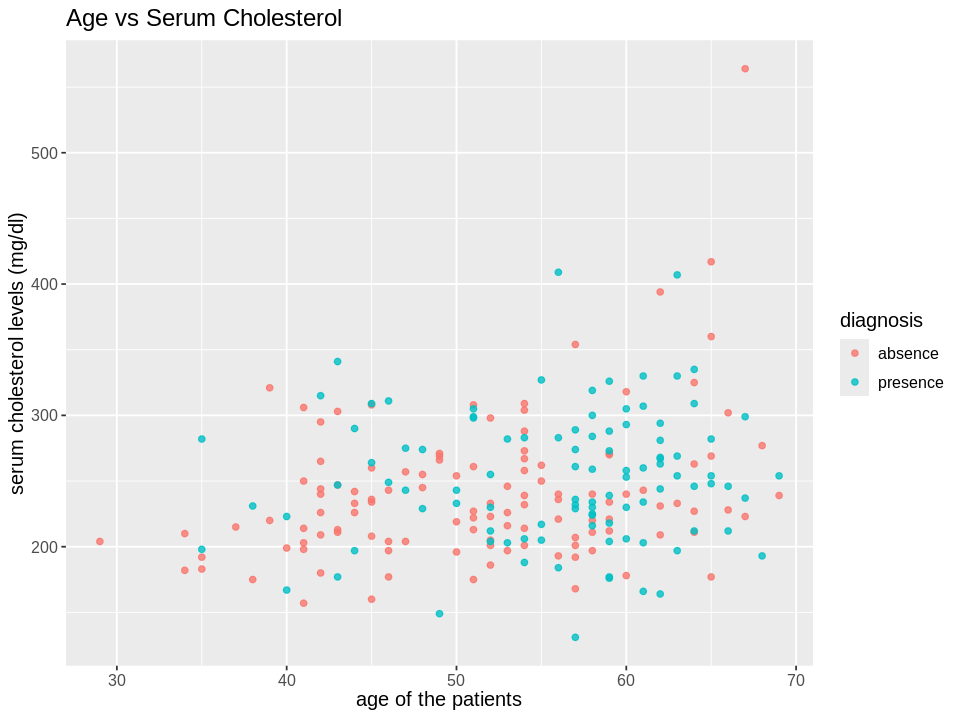

In [57]:
options(repr.plot.height = 6, repr.plot.width = 8)

heart_plot <- heart_train |>
    ggplot(aes(x = age, y = cholesterol, colour = diagnosis)) +
    geom_point(alpha = 0.8) +
    labs(x = "age of the patients",
         y = "serum cholesterol levels (mg/dl)",
         colour = "diagnosis") +
    theme(text = element_text(size = 12)) +
    ggtitle("Age vs Serum Cholesterol")
heart_plot

Figure 6

The plot shows us how the presence of heart disease increases with increasing age and serum cholesterol levels, verifying the summary of the relationship between the predictors and class. However, the data is spread out, meaning that the diagnosis is not entirely based on our predictors. 

To find the best $k$ value, 
- I create a recipe that uses all predictors and a model specification with tuning on the number of neighbours.
- Perform a 5-fold cross-validation on the training set.
- Use workflow and collect the metrics.
- Plot $k$ vs accuracy and find the best $k$.

In [74]:
#Perform Standardization
heart_recipe <- recipe(diagnosis ~ age + cholesterol, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

#Model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode ("classification")

#Perform cross-validation
heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

#Workflow and collect metrics
accuracies <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
head(accuracies)

neighbors .metric  .estimator mean      n std_err    .config              
1  1        accuracy binary     0.5670214 5 0.04021190 Preprocessor1_Model01
2  6        accuracy binary     0.5849965 5 0.01614681 Preprocessor1_Model02
3 11        accuracy binary     0.5760113 5 0.03030898 Preprocessor1_Model03
4 16        accuracy binary     0.5852079 5 0.03089994 Preprocessor1_Model04
5 21        accuracy binary     0.5945149 5 0.04391513 Preprocessor1_Model05
6 26        accuracy binary     0.6175546 5 0.04416593 Preprocessor1_Model06

Figure 7

[1] 21

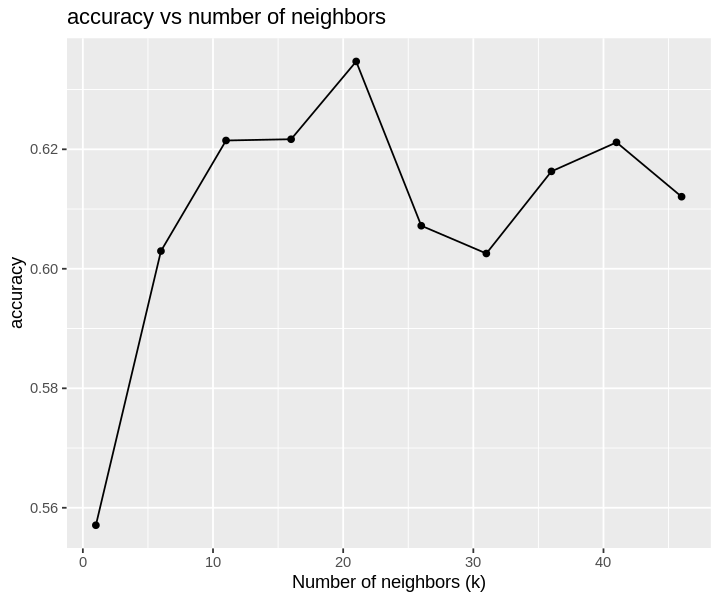

In [65]:
options(repr.plot.height = 5, repr.plot.width = 6)

k_value_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
     labs(x = "Number of neighbors (k)", 
          y = "accuracy", 
          title = "accuracy vs number of neighbors")
k_value_plot 

#To find best K
best_k <- accuracies |>
    arrange(-mean) |>
    head(1) |>
    pull(neighbors)
best_k

Figure 8

Looking at the line plot above, I will pick $k$ = 21 as the drops to either side aren't drastic and it has a high accuracy. 

With my $k$ value, I will create my final spec and fit it to my training set.

In [71]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart_spec) |>
       fit(data = heart_train)

Finally, I can use the testing set to see how our classifer performs using `predict`. Also, the accuracy, precision and recall of my classifer needs to be looked at.

In [75]:
heart_predictions <- predict(heart_fit, heart_test) |>
    bind_cols(heart_test)

#Use the metrics function
heart_metrics <- heart_predictions |>
        metrics(truth = diagnosis, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate)
heart_metrics

#Confusion matrix
heart_conf_mat <- heart_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)
heart_conf_mat

.estimate
1 0.5945946

          Truth
Prediction absence presence
  absence       22       12
  presence      18       22

Figure 9

The accuracy of my classifer is 59%, labelling 44 out of 74 correctly. 

To find the precision and accuracy, I made 'presence' as the positive label. 

In [73]:
#check the order of the labels
heart_predictions |> pull(diagnosis) |> levels()

[1] "absence"  "presence"

In [69]:
heart_predictions |> 
    precision(truth = diagnosis, estimate = .pred_class, event_level = "second")

.metric   .estimator .estimate
1 precision binary     0.5135135

Figure 10

In [70]:
heart_predictions |>
    recall(truth = diagnosis, estimate = .pred_class, event_level = "second")

.metric .estimator .estimate
1 recall  binary     0.5588235

Figure 11

To check for underfitting/overfitting, I will visualize the regions that the model has assigned to each class. 

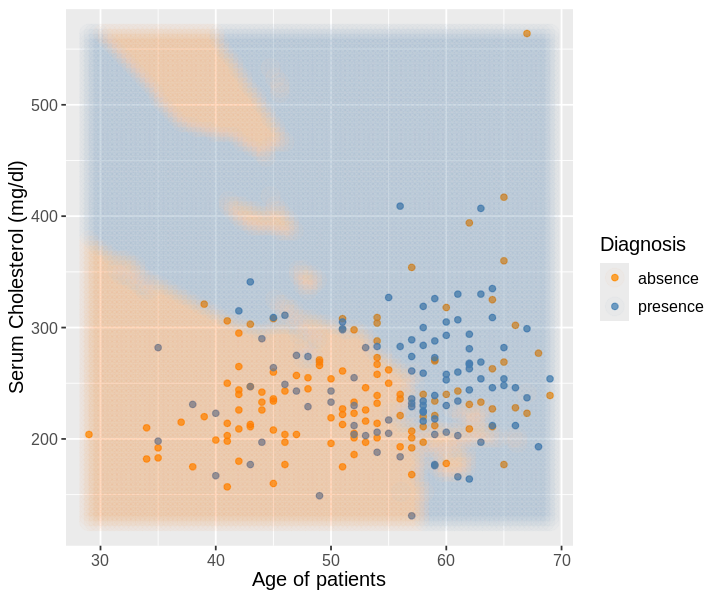

In [78]:
#Create the grid of age/cholesterol vals, and arrange in a data frame
age_grid <- seq(min(heart_filtered_data$age),
                max(heart_filtered_data$age),
                length.out = 100)

chol_grid <- seq(min(heart_filtered_data$cholesterol),
                max(heart_filtered_data$cholesterol),
                length.out = 100)

asgrid <- as_tibble(expand.grid(age = age_grid,
                                cholesterol = chol_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |>
  rename(diagnosis = .pred_class)

# plot with coloured background to check for underfitting/overfitting.
wkflw_plot <-
  ggplot() +
  geom_point(data = heart_train,
             mapping = aes(x = age,
                           y = cholesterol,
                           color = diagnosis),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = age,
                           y = cholesterol,
                           color = diagnosis),
             alpha = 0.02,
             size = 5) +
  labs(color = "Diagnosis",
       x = "Age of patients",
       y = "Serum Cholesterol (mg/dl)") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

wkflw_plot

Figure 12

Looking at the plot above, the data themselves are noisy, causing a more “jagged” boundary corresponding to a less simple model. This means that it overfits the data, hence becoming an unreliable classifer and prediction would be completely different with a different training set. The model is too influenced by the training data. Therefore, we can increase the $k$ value to improve the classifer. 

**DISCUSSION**:

Summarizing the results: 

To answer my question, I made 




**BIBLIOGRAPHY**:
